In [63]:
import requests
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, r2_score, f1_score, recall_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from hyperopt import hp, fmin, tpe
import io
import pandas as pd
from tqdm import tqdm
import numpy as np

In [2]:
link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
r = requests.get(link).content
data = pd.read_csv(io.StringIO(r.decode('utf-8')), delimiter=";")

In [10]:
data.head()
X, y = data[list(filter(lambda col_name: col_name != "quality", data.columns))], data["quality"]

1.Оцените качество по метрике accuracy для классификаторов:

DecisionTreeClassifier

BaggingClassifier со 100 деревьями

RandomForestClassifier со 100 деревьями

Сравните результаты и напишите какой вывод можно сделать.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)

In [5]:
pipe = Pipeline((
    ["clf", DecisionTreeClassifier()],
))

pipe.fit(X_train, y_train)

prediction = pipe.predict(X_test)
print(f"For DecisionTreeClassifier accuracy is: {accuracy_score(y_test, prediction) * 100:.2f}%")

For DecisionTreeClassifier accuracy is: 68.12%


In [6]:
pipe = Pipeline((
    ["clf", RandomForestClassifier(n_estimators=100)],
))

pipe.fit(X_train, y_train)

prediction = pipe.predict(X_test)
print(f"For RandomForestClassifier accuracy is: {accuracy_score(y_test, prediction) * 100:.2f}%")

For RandomForestClassifier accuracy is: 73.75%


In [7]:
pipe = Pipeline((
    ["clf", BaggingClassifier(n_estimators=100)],
))

pipe.fit(X_train, y_train)

prediction = pipe.predict(X_test)
print(f"For BaggingClassifier accuracy is: {accuracy_score(y_test, prediction) * 100:.2f}%")

For BaggingClassifier accuracy is: 74.38%


RandomForestClassifier показал наибольшую точность, но она недостаточно велика, чтобы можно было довольствоваться результатом

2.Разделите выборку на обучающую и тестовую в отношении 70%/30%

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

3.Посчитайте качество на тестовой выборке по метрике accuracy для классификатора RandomForestClassifier, используя значения деревьев:

10, 50, 100, 200, далее с шагом 200 до 5000 деревьев. Постройте график зависимости качества от числа деревьев.

100%|██████████| 28/28 [02:53<00:00,  6.21s/it]


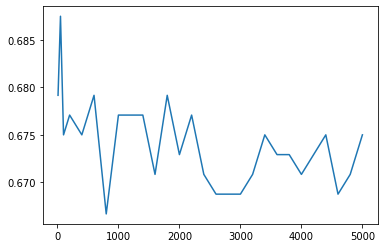

In [12]:
n_estimators = [10, 50, 100] + [i for i in range(200, 5001, 200)]

results = []

for n in tqdm(n_estimators):
    clf = RandomForestClassifier(n_estimators=n)
    clf.fit(X_train, y_train)

    results.append(accuracy_score(y_test, clf.predict(X_test)))

plt.plot(n_estimators, results)
plt.show()


4.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек sklearn и xgboost. Сравните значение метрики accuracy по cross_val_score

In [ ]:
mean_acc = cross_val_score(GradientBoostingClassifier(), X, y, scoring="accuracy").mean()
print(mean_acc)

0.5616026645768024


In [53]:
le = LabelEncoder()
le_y = le.fit_transform(y)

mean_acc = cross_val_score(XGBClassifier(), X, le_y, scoring="accuracy").mean()
print(mean_acc)

0.5690987460815047


В целом эти две модели работают почти одинаково, но градиентный бустиг из sklearn показал результат лучше на 1%

5.Подберите оптимальные параметры этих алгоритмов с помощью GridSearchCV(cv=3). Параметры для оптимизации:

оптимизируемый функционал

скорость обучения

количество деревьев

глубина деревьев

Сравните значение метрики accuracy и скорость работы. Выведите лучшие параметры алгоритмов.

In [21]:
n_estimators = [n for n in range(10, 101, 10)]
max_depth = [m for m in range(3, 8)]

In [28]:
clf = GridSearchCV(GradientBoostingClassifier(), param_grid={"n_estimators": n_estimators, "max_depth": max_depth}, cv=3)

clf.fit(X_train, y_train)
print(accuracy_score(y_test, clf.best_estimator_.predict(X_test)))
print(clf.best_params_)

0.6583333333333333
{'max_depth': 6, 'n_estimators': 70}


In [27]:
le = LabelEncoder()
le.fit(y)

le_y_train, le_y_test = le.transform(y_train), le.transform(y_test)

clf = GridSearchCV(XGBClassifier(), param_grid={"n_estimators": n_estimators, "max_depth": max_depth}, cv=3)

clf.fit(X_train, le_y_train)
print(accuracy_score(le_y_test, clf.best_estimator_.predict(X_test)))
print(clf.best_params_)

0.6416666666666667
{'max_depth': 4, 'n_estimators': 80}


6.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек lightgbm и catboost. Сравните значение метрики accuracy по cross_val_score по всем четырем реализациям.

In [25]:
mean_acc = cross_val_score(CatBoostClassifier(verbose=False), X, y, scoring="accuracy").mean()
print(mean_acc)

0.5459757053291535


In [19]:
mean_acc = cross_val_score(LGBMClassifier(), X, y, scoring="accuracy").mean()
print(mean_acc)

0.5541026645768025


Все 4 реализации из библиотек показали себя примерно одинаково с параметрами по умолчанию

7.Подберите оптимальные параметры для алгоритмов градиентного бустинга из библиотек lightgbm и catboost с теми же условиями. Выведите лучшие параметры алгоритмов. Сравните значение метрики accuracy и скорость по этим четырем реализациям.

In [22]:
clf = GridSearchCV(LGBMClassifier(), param_grid={"n_estimators": n_estimators, "max_depth": max_depth}, cv=3)

clf.fit(X_train, y_train)
print(accuracy_score(y_test, clf.best_estimator_.predict(X_test)))
print(clf.best_params_)

0.65
{'max_depth': 5, 'n_estimators': 100}


In [24]:
clf = GridSearchCV(CatBoostClassifier(verbose=False), param_grid={"n_estimators": n_estimators, "max_depth": max_depth}, cv=3)

clf.fit(X_train, y_train)
print(accuracy_score(y_test, clf.best_estimator_.predict(X_test)))
print(clf.best_params_)

0.64375
{'max_depth': 6, 'n_estimators': 50}


Точность получилась у всех алгоритмов примерно одинаковая, но по времени значительно лидирует реализация из библиотеки lightgbm - всего 17 секунд

8.Подберите оптимальные параметры алгоритма из библиотеки xgbost с помощью hyperopt . Параметры для оптимизации:

оптимизируемый функционал

скорость обучения

количество деревьев

глубина деревьев

Сравните результат с поиском по сетке из sklearn. Выведите лучшие параметры алгоритма, найденные даным способом.

In [60]:
def hyperopt_xgb_score(params):
    clf = XGBClassifier(**params)

    le = LabelEncoder()
    le_y = le.fit_transform(y)

    current_score = cross_val_score(clf, X, y, cv=3).mean()
    print(current_score, params)
    return -current_score
 
 
simple_space_xgb = {
  'n_estimators': hp.choice('n_estimators', n_estimators),
  'max_depth':  hp.choice('max_depth', max_depth),
}
 
best = fmin(
    fn=hyperopt_xgb_score, 
    space=simple_space_xgb, 
    algo=tpe.suggest, 
    max_evals=20
)
print('best:')
print(f"max_depth: {max_depth[best['max_depth']]}, n_estimators: {n_estimators[best['n_estimators']]}")

0.5428392745465916
{'max_depth': 7, 'n_estimators': 90}
0.555972482801751
{'max_depth': 6, 'n_estimators': 70}
0.557848655409631
{'max_depth': 3, 'n_estimators': 10}
0.5522201375859912
{'max_depth': 6, 'n_estimators': 100}
0.5572232645403377
{'max_depth': 3, 'n_estimators': 80}
0.5565978736710444
{'max_depth': 5, 'n_estimators': 50}
0.5447154471544715
{'max_depth': 7, 'n_estimators': 100}
0.5465916197623515
{'max_depth': 5, 'n_estimators': 80}
0.555972482801751
{'max_depth': 6, 'n_estimators': 70}
0.559724828017511
{'max_depth': 4, 'n_estimators': 60}
0.5565978736710444
{'max_depth': 5, 'n_estimators': 50}
0.5365853658536586
{'max_depth': 5, 'n_estimators': 90}
0.5741088180112571
{'max_depth': 5, 'n_estimators': 40}
0.555972482801751
{'max_depth': 6, 'n_estimators': 70}
0.5428392745465916
{'max_depth': 7, 'n_estimators': 90}
0.549718574108818
{'max_depth': 7, 'n_estimators': 70}
0.5484677923702314
{'max_depth': 3, 'n_estimators': 100}
0.5678549093183239
{'max_depth': 3, 'n_estimators':

Параметры довольно сильно отличаются, если сравнивать с поиском по сетке

9.Выведите качество по метрике accuracy стэкинга (StackingClassifier) 4-х алгоритмов с базовыми параметрами градиентного бустинга.

In [ ]:
estimators = [
    ('scikit', GradientBoostingClassifier()),
    ('rf', XGBClassifier()),
    ('lgbm', LGBMClassifier()),
    ('cat', CatBoostClassifier(verbose=False)),
]

le = LabelEncoder()
le.fit(y)

le_y_train, le_y_test = le.transform(y_train), le.transform(y_test)

clf = StackingClassifier(
  estimators=estimators
)

clf.fit(X_train, y_train)

In [73]:
accuracy_score(y_test, clf.predict(X_test))

0.6916666666666667

In [ ]:
estimators = [
    ('scikit', GradientBoostingClassifier(max_depth=6, n_estimators=70)),
    ('rf', XGBClassifier(max_depth=4, n_estimators=80)),
    ('lgbm', LGBMClassifier(max_depth=5, n_estimators=100)),
    ('cat', CatBoostClassifier(verbose=False, max_depth=6, n_estimators=50)),
]

le = LabelEncoder()
le.fit(y)

le_y_train, le_y_test = le.transform(y_train), le.transform(y_test)

clf = StackingClassifier(
  estimators=estimators
)

clf.fit(X_train, y_train)

In [77]:
accuracy_score(y_test, clf.predict(X_test))

0.6770833333333334

Лично для меня результаты крайне противоречивые

Я ожидал, что алгоритмы с оптимизированными гипер-параметрами при стекинге дадут значительно большую точность, чем алгоритмы с параметрами по умолчанию

Но получилось, что алгоритмы с параметрами по умолчанию в стекинге дают лучшую точность